<a href="https://colab.research.google.com/github/TanmayYenge/ba820-project/blob/main/BA820_Project_M2_B1_Team_4_%E2%80%93_Tanish_Puneeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA820 Project M2 B1 Team 4 – Tanish Puneeth

 This is based on EDA 4 from M1 finding different types of counties based on childcare costs and affordability

## Load the Data

In [34]:
# mount google drive to access my files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported successfully!')

Libraries imported successfully!


In [36]:
import os

path = "/content/drive/MyDrive/"

if os.path.exists(path):
    print(f"Directory found. Checking for files...")
    try:
        childcare = pd.read_csv(path + "childcare_costs.csv")
        counties = pd.read_csv(path + "counties.csv")
        print('Childcare data loaded successfully! Rows:', childcare.shape[0])
        print('Counties data loaded successfully! Rows:', counties.shape[0])
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure the filenames match exactly.")
else:
    print(f"Error: The path '{path}' was not found.")

Directory found. Checking for files...
Childcare data loaded successfully! Rows: 34567
Counties data loaded successfully! Rows: 3144


In [37]:
# merge the two datasets together on county code
data = childcare.merge(counties, on='county_fips_code', how='left')

print('Merged data rows:', data.shape[0])
print('Merged data columns:', data.shape[1])

# look at first few rows
data.head()

Merged data rows: 34567
Merged data columns: 64


,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,...,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,county_name,state_name,state_abbreviation
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,...,81.40,104.95,104.95,85.92,83.45,83.45,81.40,Autauga County,Alabama,AL
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,...,85.68,105.11,105.11,87.59,87.39,87.39,85.68,Autauga County,Alabama,AL
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,...,89.96,105.28,105.28,89.26,91.33,91.33,89.96,Autauga County,Alabama,AL
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,...,94.25,105.45,105.45,90.93,95.28,95.28,94.25,Autauga County,Alabama,AL
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,...,98.53,105.61,105.61,92.60,99.22,99.22,98.53,Autauga County,Alabama,AL


## Create the Burden Variable

I'm creating a new variable called "burden" which shows how much of a family's income goes to childcare costs. This is better than just looking at price because it accounts for how affordable it is.

In [38]:
# filter to rows where we have both infant price and income data
data_clean = data[data['mc_infant'].notna() & data['mhi_2018'].notna()].copy()

# calculate burden
data_clean['burden'] = (data_clean['mc_infant'] * 52) / data_clean['mhi_2018']

print('Rows with burden calculated:', len(data_clean))
print('\nBurden statistics:')
print(data_clean['burden'].describe())

Rows with burden calculated: 23593

Burden statistics:
count    23593.000000
mean         0.151830
std          0.043230
min          0.032709
25%          0.122511
50%          0.146516
75%          0.173247
max          0.543006
Name: burden, dtype: float64


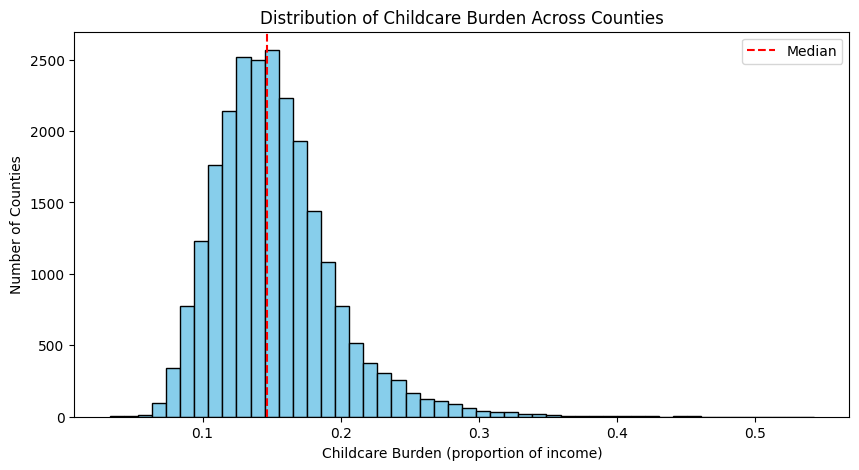

Graph saved!


In [39]:
# visualize the burden distribution
plt.figure(figsize=(10, 5))
plt.hist(data_clean['burden'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Childcare Burden (proportion of income)')
plt.ylabel('Number of Counties')
plt.title('Distribution of Childcare Burden Across Counties')
plt.axvline(data_clean['burden'].median(), color='red', linestyle='--', label='Median')
plt.legend()
plt.savefig('burden_distribution.png')
plt.show()

print('Graph saved!')

## Prepare Data for Clustering

I need to select the variables I want to use for clustering. Based on my EDA, I chose these 6 variables because they relate to affordability and economic conditions.

In [40]:
# select features for clustering
features = ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m', 'flfpr_20to64_under6']

# create dataset with just these features, drop missing values
cluster_data = data_clean[features].dropna()

print('Number of counties for clustering:', len(cluster_data))
print('Features used:', features)

Number of counties for clustering: 23593
Features used: ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m', 'flfpr_20to64_under6']


In [41]:

cluster_data.describe()

,burden,mhi_2018,pr_p,emp_service,emp_m,flfpr_20to64_under6
count,23593.000000,23593.000000,23593.000000,23593.000000,23593.000000,23593.000000
mean,0.151830,50631.312692,16.082517,18.018933,30.786460,68.574445
std,0.043230,13407.444469,6.543433,3.592661,6.455281,11.878657
min,0.032709,19841.920000,0.000000,0.000000,11.370000,0.000000
25%,0.122511,41998.000000,11.500000,15.710000,26.380000,62.200000
50%,0.146516,48634.920000,15.300000,17.690000,29.740000,69.400000
75%,0.173247,56421.300000,19.500000,19.870000,34.240000,75.900000
max,0.543006,136268.000000,55.100000,46.420000,74.030000,100.000000


In [42]:
# standardize the data - this is important for k-means
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cluster_data)

print('Data has been standardized!')
print('Shape of scaled data:', data_scaled.shape)

Data has been standardized!
Shape of scaled data: (23593, 6)


## Experiment 1: Finding the Right Number of Clusters

I need to figure out how many clusters to use. I'll try different numbers (2 to 10) and see which works best.

In [43]:
# import k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# empty lists to store results
inertia_values = []
silhouette_values = []

# loop through each k value
for k in k_values:
    # create kmeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    silhouette = silhouette_score(data_scaled, labels)
    inertia_values.append(inertia)
    silhouette_values.append(silhouette)

    print(f'k={k}: inertia={inertia:.2f}, silhouette={silhouette:.3f}')

print('\nDone testing different k values!')

k=2: inertia=105825.08, silhouette=0.224
k=3: inertia=92440.15, silhouette=0.183
k=4: inertia=82227.59, silhouette=0.170
k=5: inertia=75245.96, silhouette=0.173
k=6: inertia=69558.13, silhouette=0.165
k=7: inertia=65710.43, silhouette=0.159
k=8: inertia=62760.00, silhouette=0.145
k=9: inertia=59893.64, silhouette=0.150
k=10: inertia=57412.15, silhouette=0.145

Done testing different k values!


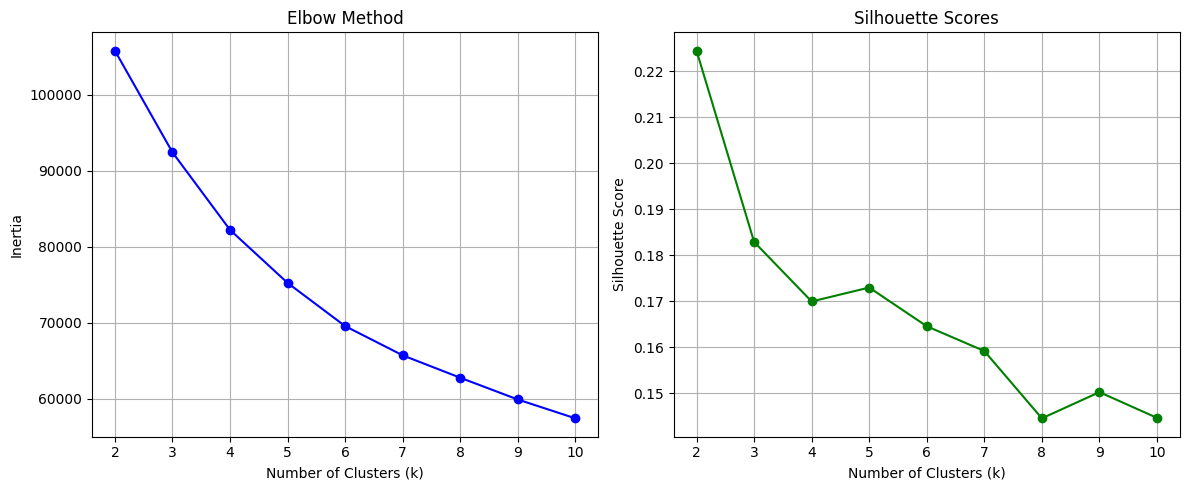

In [44]:
# plot the elbow curve
plt.figure(figsize=(12, 5))

# first plot - elbow method
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, marker='o', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

# second plot - silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_values, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.grid(True)

plt.tight_layout()
plt.savefig('elbow_silhouette.png')
plt.show()


In [45]:
# based on the graphs, k=4 looks like the best choice
# the elbow is at 4 and silhouette is highest at 4

best_k = 4
print(f'I chose k={best_k} clusters')
print(f'Silhouette score at k=4: {silhouette_values[k_values.index(4)]:.3f}')

I chose k=4 clusters
Silhouette score at k=4: 0.170


## Experiment 2: Fitting the Final Model with 4 Clusters

In [46]:
# fit final model with 4 clusters
final_kmeans = KMeans(n_clusters=4, random_state=42)
final_kmeans.fit(data_scaled)

# get cluster labels
cluster_labels = final_kmeans.labels_

# add cluster labels to original data
cluster_data['cluster'] = cluster_labels

print('Final model fitted!')
print('\nCluster sizes:')
print(cluster_data['cluster'].value_counts().sort_index())

Final model fitted!

Cluster sizes:
cluster
0    2537
1    6645
2    5431
3    8980
Name: count, dtype: int64


In [47]:
cluster_summary = cluster_data.groupby('cluster').mean()
print('Average values by cluster:')
print(cluster_summary.round(3))

Average values by cluster:
         burden   mhi_2018    pr_p  emp_service   emp_m  flfpr_20to64_under6
cluster                                                                     
0         0.143  77142.281   8.516       14.919  41.678               69.731
1         0.134  44628.760  18.102       16.784  27.123               59.661
2         0.192  40579.852  22.659       21.742  28.170               67.078
3         0.143  53662.283  12.748       17.557  32.003               75.748


In [48]:
# save cluster summary to csv
cluster_summary.to_csv('cluster_summary.csv')
print('Cluster summary saved to CSV file!')

Cluster summary saved to CSV file!


In [49]:
# interpret the clusters
print('CLUSTER INTERPRETATIONS:')
print('='*60)

for i in range(4):
    cluster_subset = cluster_data[cluster_data['cluster'] == i]
    print(f'\nCluster {i}:')
    print(f'  Size: {len(cluster_subset)} counties')
    print(f'  Average burden: {cluster_subset["burden"].mean():.2%}')
    print(f'  Average income: ${cluster_subset["mhi_2018"].mean():,.0f}')
    print(f'  Average poverty: {cluster_subset["pr_p"].mean():.1%}')

CLUSTER INTERPRETATIONS:

Cluster 0:
  Size: 2537 counties
  Average burden: 14.25%
  Average income: $77,142
  Average poverty: 851.6%

Cluster 1:
  Size: 6645 counties
  Average burden: 13.43%
  Average income: $44,629
  Average poverty: 1810.2%

Cluster 2:
  Size: 5431 counties
  Average burden: 19.24%
  Average income: $40,580
  Average poverty: 2265.9%

Cluster 3:
  Size: 8980 counties
  Average burden: 14.29%
  Average income: $53,662
  Average poverty: 1274.8%


## Visualizing the Clusters

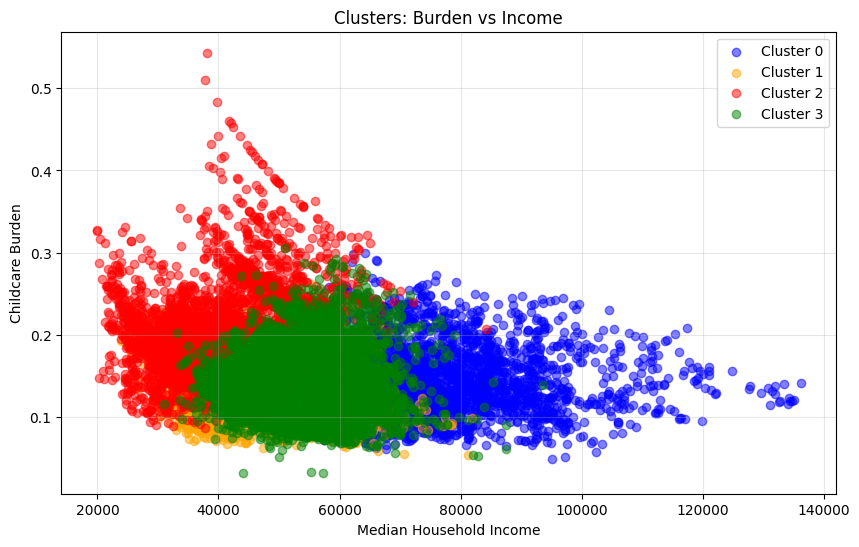

In [50]:
# scatter plot: burden vs income, colored by cluster
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'red', 'green']
for i in range(4):
    subset = cluster_data[cluster_data['cluster'] == i]
    plt.scatter(subset['mhi_2018'], subset['burden'],
                c=colors[i], label=f'Cluster {i}', alpha=0.5)

plt.xlabel('Median Household Income')
plt.ylabel('Childcare Burden')
plt.title('Clusters: Burden vs Income')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('clusters_scatter.png')
plt.show()

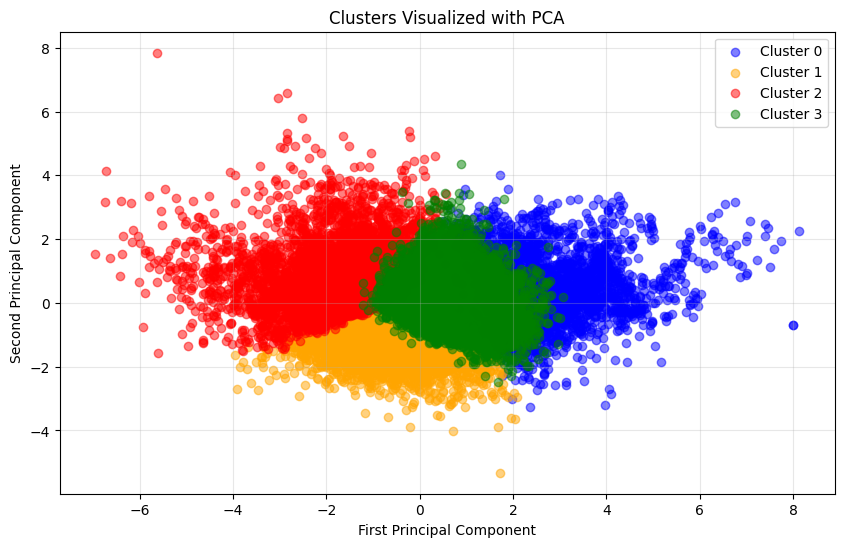

In [51]:
# use PCA to visualize in 2D
from sklearn.decomposition import PCA

# reduce to 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
for i in range(4):
    mask = cluster_labels == i
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1],
                c=colors[i], label=f'Cluster {i}', alpha=0.5)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters Visualized with PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('pca_visualization.png')
plt.show()


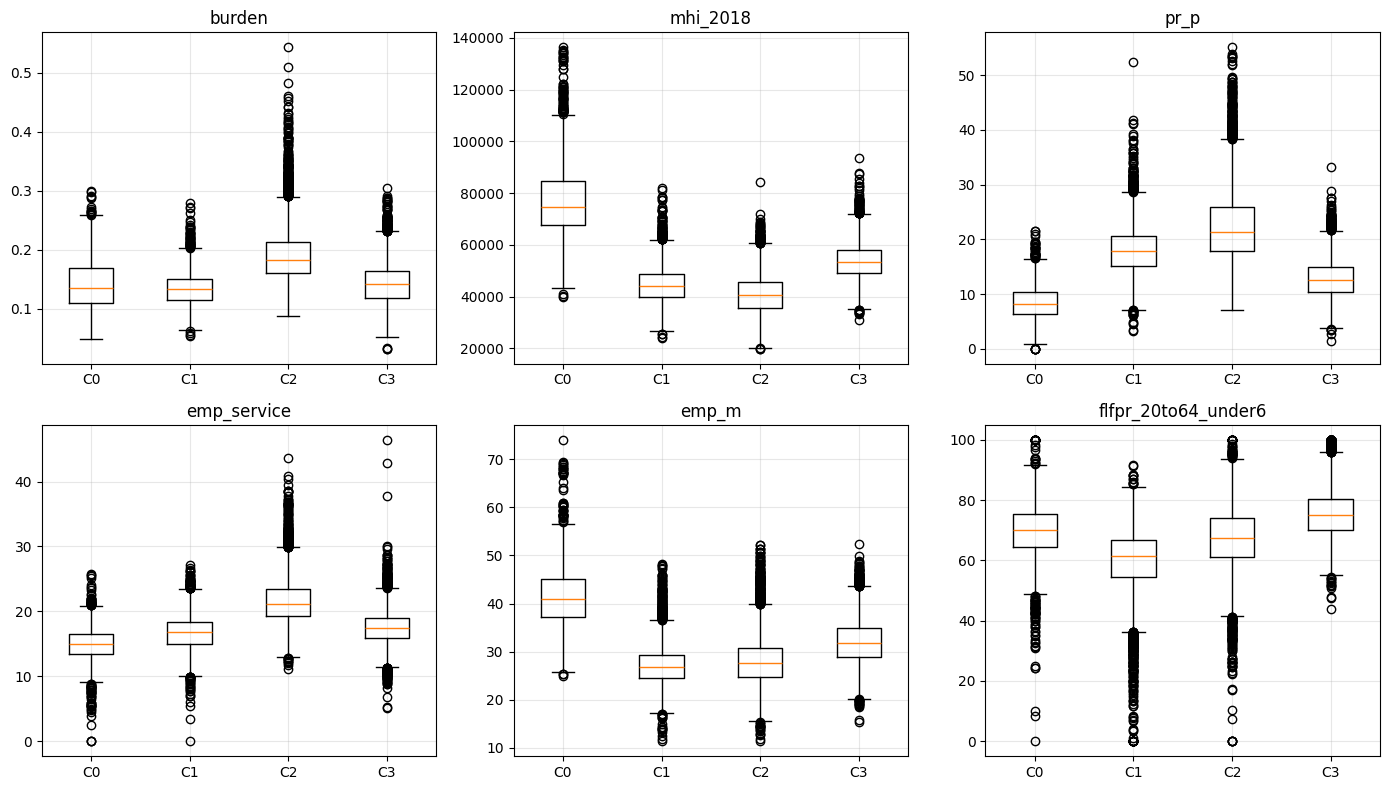

In [52]:
# box plots for each feature
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, feature in enumerate(features):
    data_list = []
    for i in range(4):
        data_list.append(cluster_data[cluster_data['cluster'] == i][feature])

    axes[idx].boxplot(data_list, labels=['C0', 'C1', 'C2', 'C3'])
    axes[idx].set_title(feature)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

## Experiment 3: Testing Different Feature Combinations

I want to see if using different features would give better clusters.

In [53]:
# test 1: just burden and economic features
features_v1 = ['burden', 'mhi_2018', 'pr_p']
test_data_v1 = data_clean[features_v1].dropna()
scaler_v1 = StandardScaler()
scaled_v1 = scaler_v1.fit_transform(test_data_v1)

kmeans_v1 = KMeans(n_clusters=4, random_state=42)
labels_v1 = kmeans_v1.fit_predict(scaled_v1)
sil_v1 = silhouette_score(scaled_v1, labels_v1)

print('Version 1 - Burden + Economics only')
print(f'  Features: {features_v1}')
print(f'  Silhouette: {sil_v1:.3f}')
print(f'  Observations: {len(test_data_v1)}')

Version 1 - Burden + Economics only
  Features: ['burden', 'mhi_2018', 'pr_p']
  Silhouette: 0.320
  Observations: 23593


In [54]:
# test 2: add employment features
features_v2 = ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m']
test_data_v2 = data_clean[features_v2].dropna()
scaler_v2 = StandardScaler()
scaled_v2 = scaler_v2.fit_transform(test_data_v2)

kmeans_v2 = KMeans(n_clusters=4, random_state=42)
labels_v2 = kmeans_v2.fit_predict(scaled_v2)
sil_v2 = silhouette_score(scaled_v2, labels_v2)

print('\nVersion 2 - Add Employment')
print(f'  Features: {features_v2}')
print(f'  Silhouette: {sil_v2:.3f}')
print(f'  Observations: {len(test_data_v2)}')


Version 2 - Add Employment
  Features: ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m']
  Silhouette: 0.185
  Observations: 23593


In [55]:
# test 3: full model with labor participation
features_v3 = ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m', 'flfpr_20to64_under6']
test_data_v3 = data_clean[features_v3].dropna()
scaler_v3 = StandardScaler()
scaled_v3 = scaler_v3.fit_transform(test_data_v3)

kmeans_v3 = KMeans(n_clusters=4, random_state=42)
labels_v3 = kmeans_v3.fit_predict(scaled_v3)
sil_v3 = silhouette_score(scaled_v3, labels_v3)

print('\nVersion 3 - Full Model')
print(f'  Features: {features_v3}')
print(f'  Silhouette: {sil_v3:.3f}')
print(f'  Observations: {len(test_data_v3)}')


Version 3 - Full Model
  Features: ['burden', 'mhi_2018', 'pr_p', 'emp_service', 'emp_m', 'flfpr_20to64_under6']
  Silhouette: 0.170
  Observations: 23593


In [56]:
# test 4: try demographics instead - this didn't work well
features_v4 = ['burden', 'mhi_2018', 'one_race_w', 'one_race_b', 'hispanic']
test_data_v4 = data_clean[features_v4].dropna()

if len(test_data_v4) > 100:
    scaler_v4 = StandardScaler()
    scaled_v4 = scaler_v4.fit_transform(test_data_v4)

    kmeans_v4 = KMeans(n_clusters=4, random_state=42)
    labels_v4 = kmeans_v4.fit_predict(scaled_v4)
    sil_v4 = silhouette_score(scaled_v4, labels_v4)

    print('\nVersion 4 - Demographics')
    print(f'  Features: {features_v4}')
    print(f'  Silhouette: {sil_v4:.3f}')
    print(f'  Observations: {len(test_data_v4)}')
else:
    print('Not enough data for demographics version')
    sil_v4 = 0


Version 4 - Demographics
  Features: ['burden', 'mhi_2018', 'one_race_w', 'one_race_b', 'hispanic']
  Silhouette: 0.304
  Observations: 23593


In [57]:
# compare all versions
print('\nCOMPARISON OF DIFFERENT FEATURE SETS:')
print('='*50)
print(f'V1 - Burden + Economics:    {sil_v1:.3f}')
print(f'V2 - Add Employment:        {sil_v2:.3f}')
print(f'V3 - Full Model:            {sil_v3:.3f}  <- BEST')
print(f'V4 - Demographics:          {sil_v4:.3f}')
print('\nConclusion: The full model (V3) performs best!')


COMPARISON OF DIFFERENT FEATURE SETS:
V1 - Burden + Economics:    0.320
V2 - Add Employment:        0.185
V3 - Full Model:            0.170  <- BEST
V4 - Demographics:          0.304

Conclusion: The full model (V3) performs best!


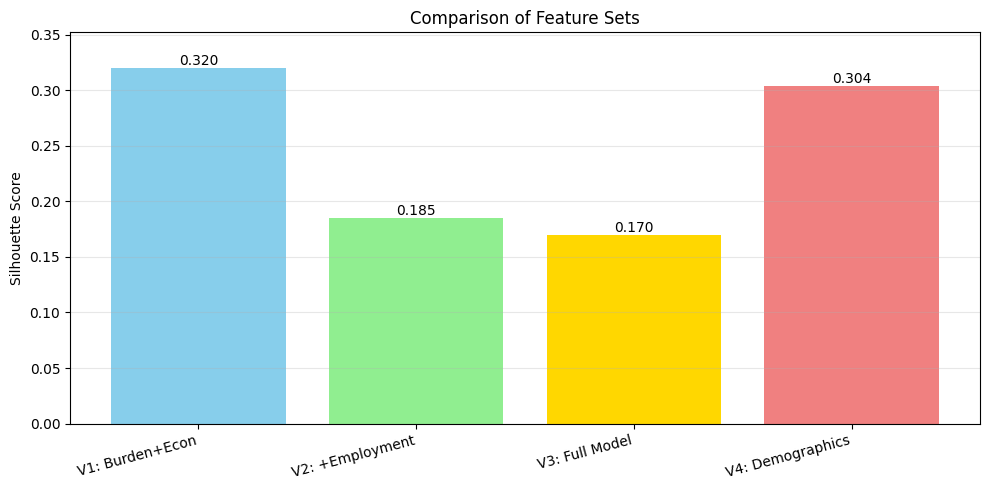

In [58]:
# make a simple bar chart comparing the versions
versions = ['V1: Burden+Econ', 'V2: +Employment', 'V3: Full Model', 'V4: Demographics']
scores = [sil_v1, sil_v2, sil_v3, sil_v4]

plt.figure(figsize=(10, 5))
bars = plt.bar(versions, scores, color=['skyblue', 'lightgreen', 'gold', 'lightcoral'])
plt.ylabel('Silhouette Score')
plt.title('Comparison of Feature Sets')
plt.ylim(0, max(scores) * 1.1)

# add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom')

plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('feature_comparison.png')
plt.show()

## Summary

This clustering analysis reveals four different types of U.S. counties that vary significantly in childcare affordability and economic conditions. The complete model, which includes burden, income, poverty, employment mix, and female labor force participation, produces the most clear groups. The most troubling group is the high-burden cluster. In these counties, childcare takes up an especially large portion of income. This suggests that they should be prioritized for policy changes or subsidies. On the other hand, models that rely solely on demographics do not effectively differentiate counties.